<a href="https://colab.research.google.com/github/yueop/AS_LAB/blob/main/compare_fashion_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from google.colab import drive

# 1. 드라이브 마운트
drive.mount('/content/drive')

# 2. 경로 설정
PROJECT_PATH = '/content/drive/MyDrive/AS_LAB'
if not os.path.exists(PROJECT_PATH):
    os.makedirs(PROJECT_PATH)

# 3. 시스템 경로 추가 및 작업 디렉토리 변경
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
os.chdir(PROJECT_PATH)

print(f"현재 위치: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
현재 위치: /content/drive/MyDrive/AS_LAB


데이터 로드 중...
3가지 모델 로드 완료!
오분류 데이터 수집 중...
수집된 샘플 수: 20
결과 저장 완료: fashion_mnist_comparison.png


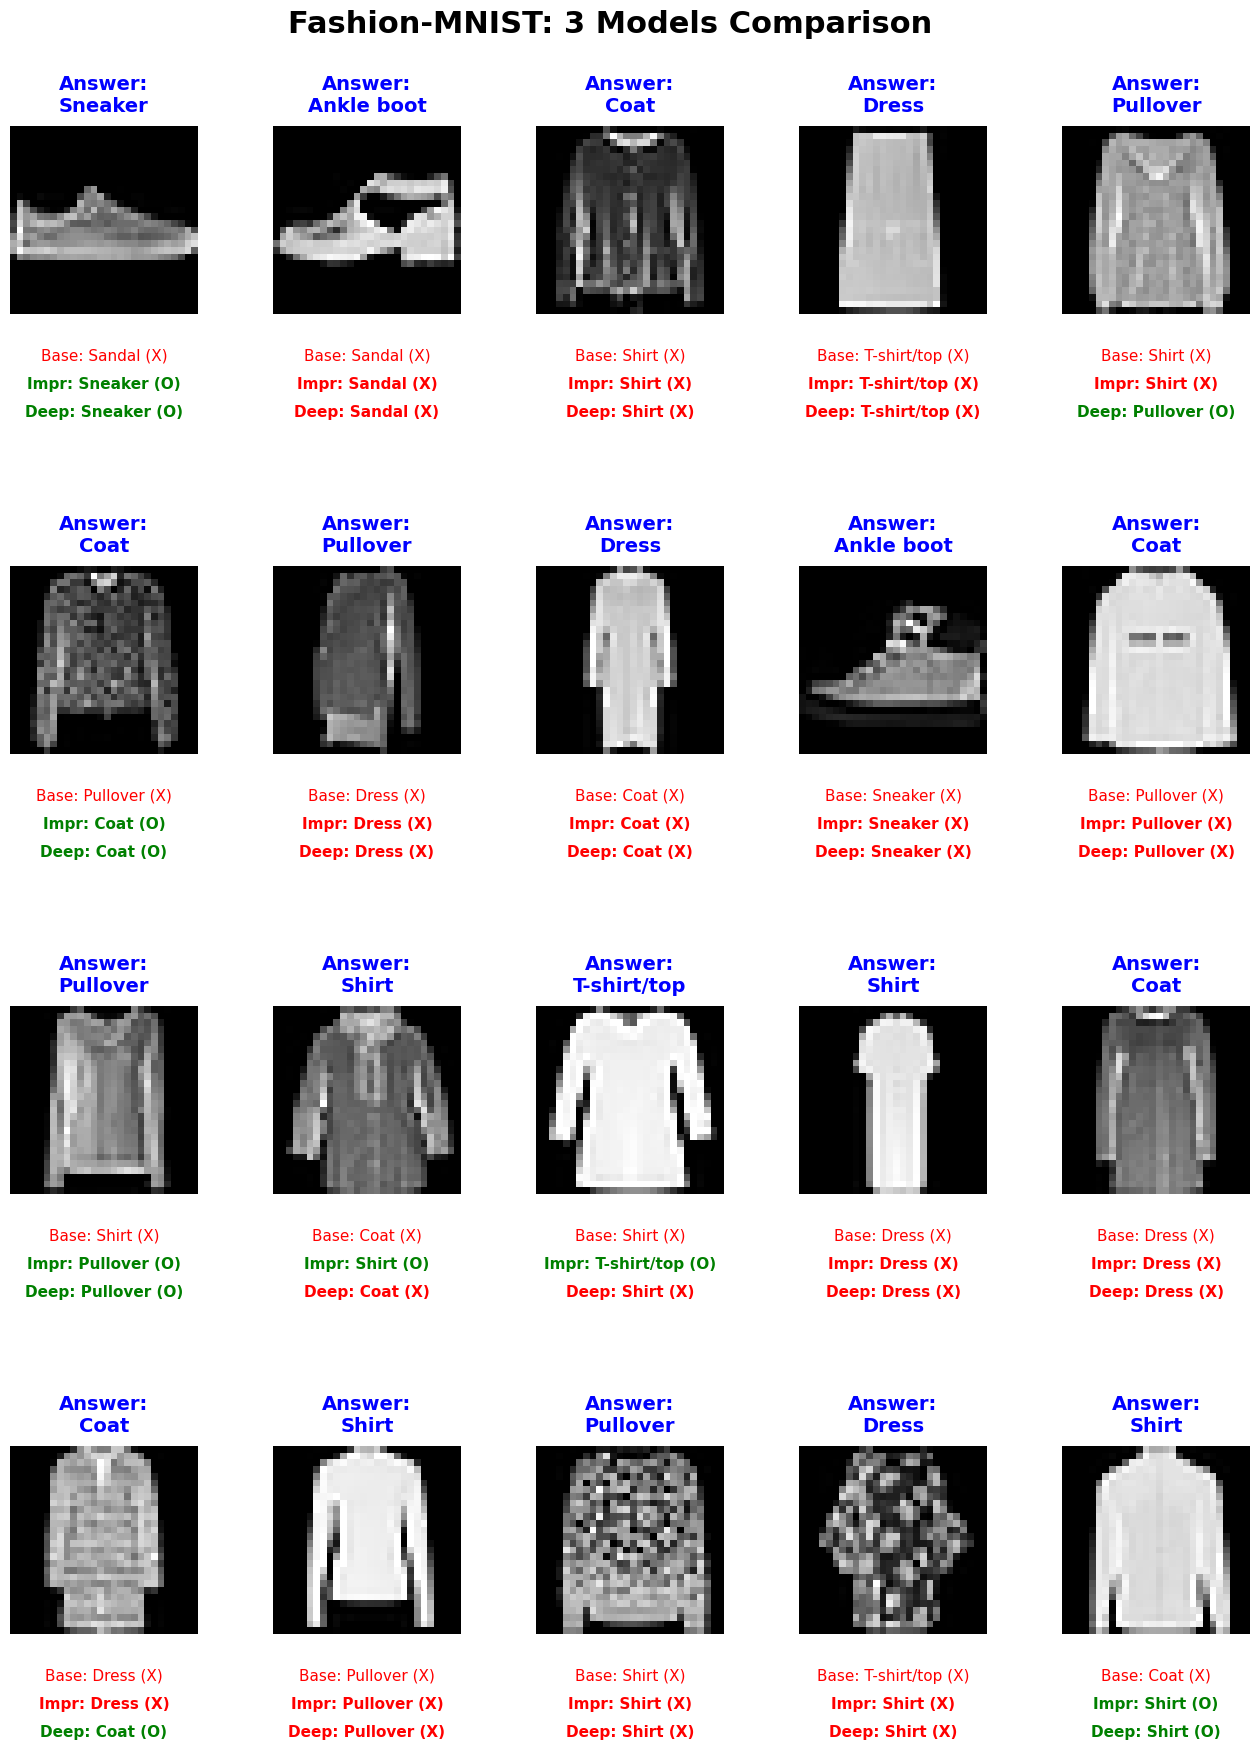

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import random

#모델 및 데이터 로더 임포트
from models import CNN, ImprovedCNN, DeepCNN
from my_datasets import UnifiedDataLoader

FILE_NAME = 'compare_fashion_mnist.png'
SAVE_PATH = f"/content/drive/MyDrive/AS_LAB/{FILE_NAME}"

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

# 1. 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fashion-MNIST 라벨 맵 (숫자 -> 이름)
label_map = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

cfg = {
    'data': {
        'batch_size': 1000,
        'split_ratio': 0.2,
        'augmentation': {'use_aug': False}
    },
    'train': {'seed': 42}
}

# 2. 데이터 로드 (fashion_mnist로 변경)
print("데이터 로드 중...")
data_loader = UnifiedDataLoader(cfg)
test_loader = data_loader.get_loader('fashionmnist', mode='test')

# 3. 최고 성능 모델 3개 준비
path_model_1 = 'best_fashion_mnist_cnn.pth'          # Baseline
path_model_2 = 'best_fashion_mnist_improvedcnn.pth'     # Improved
path_model_3 = 'best_fashion_mnist_deepcnn.pth'         # Deep

try:
    # 모델 1 (Baseline)
    model_1 = CNN(num_classes=10).to(device)
    model_1.load_state_dict(torch.load(path_model_1, map_location=device))
    model_1.eval()

    # 모델 2 (Improved)
    model_2 = ImprovedCNN(num_classes=10).to(device)
    model_2.load_state_dict(torch.load(path_model_2, map_location=device))
    model_2.eval()

    # 모델 3 (Deep)
    model_3 = DeepCNN(num_classes=10).to(device)
    model_3.load_state_dict(torch.load(path_model_3, map_location=device))
    model_3.eval()

    print("3가지 모델 로드 완료!")
except Exception as e:
    print(f"모델 로드 실패: {e}")
    # 코드가 멈추지 않도록 예외처리 (실제로는 멈추고 경로 수정해야 함)


# 4. 비교 분석 함수 (3개 모델용)
def find_failures_3models(loader, m1, m2, m3, count=20):
    failure_samples = [] # (이미지, 정답, M1예측, M2예측, M3예측)

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            pred_1 = m1(data).argmax(dim=1, keepdim=True)
            pred_2 = m2(data).argmax(dim=1, keepdim=True)
            pred_3 = m3(data).argmax(dim=1, keepdim=True)

            for i in range(len(data)):
                # 기준: 가장 성능이 낮은 모델(M1)이 틀린 것 위주로 수집
                if pred_1[i].item() != target[i].item():
                    failure_samples.append((
                        data[i].cpu(),
                        target[i].item(),
                        pred_1[i].item(),
                        pred_2[i].item(),
                        pred_3[i].item()
                    ))

                if len(failure_samples) >= count:
                    return failure_samples
    return failure_samples

# 5. 실행 및 시각화
if 'model_1' in locals() and 'model_2' in locals():
    print("오분류 데이터 수집 중...")
    samples = find_failures_3models(test_loader, model_1, model_2, model_3, count=20)
    print(f"수집된 샘플 수: {len(samples)}")

    if len(samples) > 0:
        # 세로 길이를 더 늘림 (텍스트가 3줄이라 공간 필요)
        fig = plt.figure(figsize=(16, 20))
        fig.suptitle(f"Fashion-MNIST: 3 Models Comparison", fontsize=22, y=0.93, fontweight='bold')

        # hspace를 1.0으로 늘려 텍스트 겹침 방지
        plt.subplots_adjust(wspace=0.4, hspace=1.0)

        for idx, (img, label, p1, p2, p3) in enumerate(samples):
            ax = fig.add_subplot(4, 5, idx+1) # 4행 5열

            img_np = img.squeeze().numpy()
            ax.imshow(img_np, cmap='gray')

            # 정답 라벨 표시
            label_name = label_map[label]
            ax.set_title(f"Answer:\n{label_name}", fontsize=14, fontweight='bold', color='blue', pad=10)

            # --- 결과 텍스트 표시 ---

            # Model 1 (Baseline) - 기준이니까 항상 틀린 상태(Red)
            p1_name = label_map[p1]
            ax.text(0.5, -0.25, f"Base: {p1_name} (X)",
                    color='red', ha='center', transform=ax.transAxes, fontsize=11)

            # Model 2 (Improved)
            p2_name = label_map[p2]
            color_2 = 'green' if p2 == label else 'red'
            mark_2 = 'O' if p2 == label else 'X'
            ax.text(0.5, -0.40, f"Impr: {p2_name} ({mark_2})",
                    color=color_2, ha='center', transform=ax.transAxes, fontsize=11, fontweight='bold')

            # Model 3 (Deep)
            p3_name = label_map[p3]
            color_3 = 'green' if p3 == label else 'red'
            mark_3 = 'O' if p3 == label else 'X'
            ax.text(0.5, -0.55, f"Deep: {p3_name} ({mark_3})",
                    color=color_3, ha='center', transform=ax.transAxes, fontsize=11, fontweight='bold')

            ax.axis('off')

        save_path = 'fashion_mnist_comparison.png'
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"결과 저장 완료: {save_path}")
        plt.show()